# Introduction

**In this lecture, we will learn**
- what an intensity transformation is,
- when and how to use common intensity transformations,
- principles of histogram equalization and matching techniques,
- how to implement intensity transformations efficiently using Numpy.

**The lecture is based on**
- Chapter 3 "Point Operations" of  
  [\[Burger22\] Wilhelm Burger, Mark J. Burge: "Digital Image Processing: An Algorithmic Introduction (3rd edition)"](https://imagingbook.com/books/english-edition-hardcover/)

In [1]:
from typing import Callable, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import skimage

In [2]:
xray_rgb = skimage.io.imread('../data/xray.bmp')
xray_rgb.dtype, xray_rgb.shape, xray_rgb.min(), xray_rgb.max()

(dtype('uint8'), (474, 600, 3), np.uint8(78), np.uint8(129))

In [3]:
xray_gray = skimage.util.img_as_ubyte(skimage.color.rgb2gray(xray_rgb))
xray_gray.dtype, xray_gray.shape, xray_gray.min(), xray_gray.max()

(dtype('uint8'), (474, 600), np.uint8(78), np.uint8(129))

In [4]:
def imshow_pair(
        horizontal: bool = True,
        cmap: str = 'gray',
        vmin: Union[int, float] = 0,
        vmax: Union[int, float] = 255,
        grid: bool = False,
        colorbar: bool = True,
        **images
):
    nrows, ncols = (1, 2) if horizontal else (2, 1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained')
    for ax, (name, img) in zip(axes.flat, images.items()):
        im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.grid(grid)
        ax.set_title(name)
    if colorbar:
        fig.colorbar(im, ax=axes, orientation='horizontal' if horizontal else 'vertical', aspect=50)
    return fig, axes

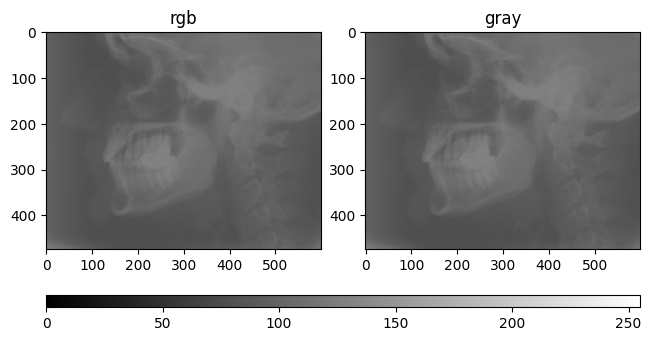

In [5]:
imshow_pair(rgb=xray_rgb, gray=xray_gray);

# Intensity transformations

<figure class="image">
  <img src="../figures/intensity_transformations-examples.png" alt="" style="width: 6.4in;"/>
  <figcaption>Examples of intensity transformations: original, negative, histogram equalization, segmentation by thresholding</figcaption>
</figure>

- In general, an intensity transformation is
  $$
  g(x, y) = T(f(x, y), x, y)
  $$
  where
  - $f(x, y)$ is the original image,
  - $T$ is a transformation function,
  - $g(x, y)$ is the newly produced transformed image.
- Notice that the output value $g(x, y)$ at position $(x, y)$ only depends on input $f(x, y)$ at the same coordinates $(x, y)$ and the coordinates themselves.
- This means that **intensity transformations do not change size, geometry or local structure of the image**.

# Monadic operations

- A special category of intensity transformations are monadic (unary, single input) operations that are **independent of the position $(x, y)$** in the image.
  $$
  g(x, y) = T(f(x, y))
  $$
  or more succinctly
  $$
  b = T(a)
  $$
  where
  - $a = f(x, y)$ is the original intensity,
  - $b = g(x, y)$ the transformed intensity.
- In other words, the transformed intensity value only depends on the original intensity and nothing else.

## Change of brightness

- Brightness roughly corresponds to image exposure.
- **Manipulating brightness has an additive effect**
  $$
  T_{\textrm{br}}(a; \beta) = a + \beta
  $$
- For example, to increase the brightness by 10, we would do $T_{\textrm{br}}(a; 10) = a + 10$

In [6]:
def change_brightness(img: np.ndarray, beta: float) -> np.ndarray:
    height, width = img.shape
    # First initialize an output image - same size and type as input
    output = np.zeros_like(img)
    for y in range(height):
        for x in range(width):
            # For each pixel do b = T(a) = a + beta
            a = img[y, x]
            b = a + beta  # FIXME: a problem here
            b = np.clip(b, 0, 255)
            # Write the new intensity in the output image to the same position
            output[y, x] = b
    return output

In [7]:
gray_brt = change_brightness(xray_gray, 50)
gray_brt.dtype, gray_brt.shape, gray_brt.min(), gray_brt.max()

(dtype('uint8'), (474, 600), np.uint8(128), np.uint8(179))

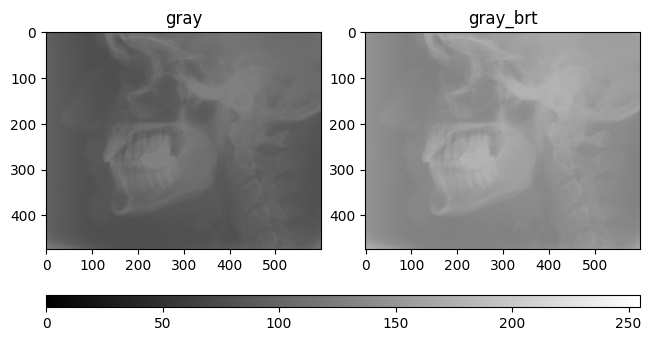

In [8]:
imshow_pair(gray=xray_gray, gray_brt=gray_brt);

## Change of contrast

- Contrast corresponds to the range of intensity values effectively used in an image.
- **Manipulating contrast has a multiplicative effect**
  $$
  T_{\textrm{con}}(a; \alpha) = \alpha \cdot a
  $$
- For example, to increase the contrast by 50 %, we would do $T_{\textrm{con}}(a; 1.5) = 1.5\cdot a$

In [9]:
def change_contrast(img: np.ndarray, alpha: float) -> np.ndarray:
    height, width = img.shape
    output = np.zeros_like(img)
    for y in range(height):
        for x in range(width):
            output[y, x] = alpha * img[y, x]  # FIXME: a problem here
    return output

In [10]:
gray_con = change_contrast(xray_gray, 1.5)
gray_con.dtype, gray_con.shape, gray_con.min(), gray_con.max()

(dtype('uint8'), (474, 600), np.uint8(117), np.uint8(193))

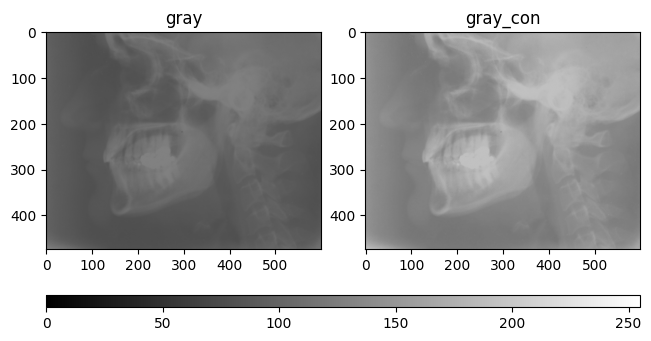

In [11]:
imshow_pair(gray=xray_gray, gray_con=gray_con);

# Inverting an image (image negative)

- The transformation function is
  $$T_{\text{neg}}(a) = a_\text{max} - a$$
- where
  - $a_\text{max} = 2^{n_\text{bits}}$ when the dtype is integer (typically $n_\text{bits} = 8 \rightarrow a_\text{max} = 255$),
  - $a_\text{max} = 1.0$ when the dtype is `float`.

In [12]:
def image_negative_slow(img: np.ndarray, v_max: int = 255) -> np.ndarray:
    height, width = img.shape
    output = np.zeros_like(img)
    for y in range(height):
        for x in range(width):
            output[y, x] = v_max - img[y, x]
    return output

In [13]:
xray_neg = image_negative_slow(xray_gray)
xray_neg.dtype, xray_neg.shape, xray_neg.min(), xray_neg.max()

(dtype('uint8'), (474, 600), np.uint8(126), np.uint8(177))

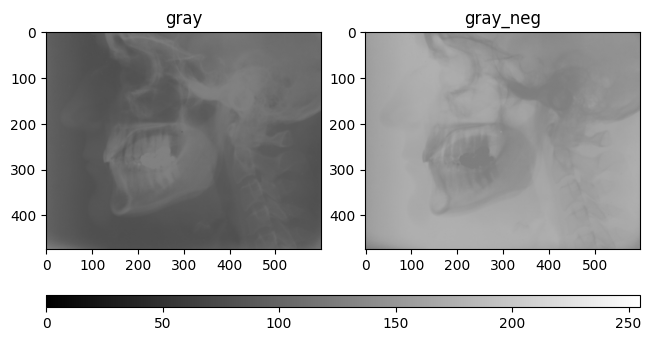

In [14]:
imshow_pair(gray=xray_gray, gray_neg=xray_neg);

## Fast vectorized implementation

- We'll ditch the slow Python for loops and leverage NumPy's efficient broadcasting instead.

In [15]:
def image_negative(img: np.ndarray, v_max: int = 255) -> np.ndarray:
    return v_max - img

In [16]:
xray_neg = image_negative(xray_gray)
xray_neg.dtype, xray_neg.shape, xray_neg.min(), xray_neg.max()

(dtype('uint8'), (474, 600), np.uint8(126), np.uint8(177))

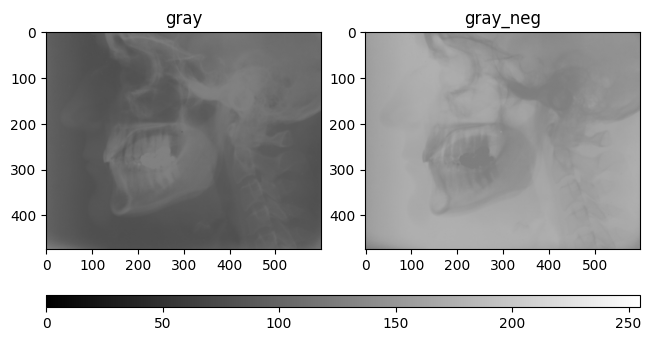

In [17]:
imshow_pair(gray=xray_gray, gray_neg=xray_neg);

In [18]:
%timeit image_negative_slow(xray_gray)

53.6 ms ± 209 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit image_negative(xray_gray)

119 μs ± 836 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Thresholding

- Thresholding is an intensity transformation function that separates pixels by their value into two classes, for example background and foreground.
  $$
  T_{\textrm{thr}}(a; t) = \begin{cases}
      a_\textrm{min} & \textrm{if} \; a \lt t \\
      a_\textrm{max} & \textrm{if} \; a \ge t
  \end{cases}
  $$
  where
  - $t$ is some threshold value.
- Usually, we want to *binarize* the image and therefore choose $a_\textrm{min} = 0$ and $a_\textrm{max} = 1$ (or sometimes 0 and 255 in case of `uint8` images).

In [20]:
def threshold_image(img: np.ndarray, threshold: int, v_max: int = 255) -> np.ndarray:
    output = np.zeros_like(img)
    mask = img >= threshold
    output[mask] = v_max
    return output

In [21]:
gray_thr = threshold_image(xray_gray, 125)
gray_thr.dtype, gray_thr.shape, gray_thr.min(), gray_thr.max()

(dtype('uint8'), (474, 600), np.uint8(0), np.uint8(255))

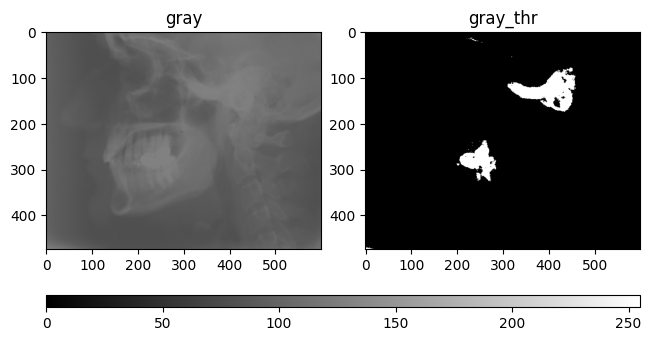

In [22]:
imshow_pair(gray=xray_gray, gray_thr=gray_thr);

# Automatic contrast adjustment (enhancement)

- Let's first look at the image histogram of our low contrast image.

In [23]:
xray_hist_bins = np.arange(257)
xray_hist, _ = np.histogram(xray_gray, bins=xray_hist_bins)

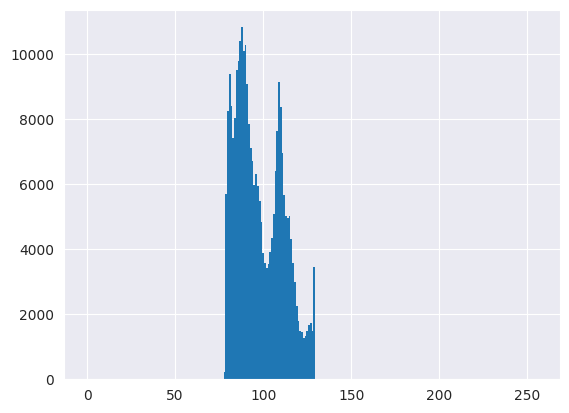

In [24]:
with sns.axes_style(style='darkgrid'):
    plt.bar(xray_hist_bins[:-1], xray_hist, width=1., edgecolor='none');

- If the image only covers a small range of intensities, it may appear as low contrast.
- In order to increase the contrast, we need to fully utilize the entire range of possible intensities like in the following picture.

<figure class="image">
  <img src="../figures/intensity_transformations-auto_contrast_adjust.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 3.4</figcaption>
</figure>

- Let's say the smallest and the highest values in our image $I$ are $a_\textrm{lo} = \min(I)$ and $a_\textrm{hi} = \max(I)$, respectively.

In [25]:
xray_gray.min(), xray_gray.max()

(np.uint8(78), np.uint8(129))

- In order to cover some specified intensity range, we will map the smallest value $a_\textrm{lo}$ to zero (let's call that zero $a_\textrm{min}$) and the highest value $a_\textrm{hi}$ to 255 ($=a_\textrm{max}$) like so
  $$
  f(a) = \frac{a_\textrm{max} - a_\textrm{min}}{a_\textrm{hi} - a_\textrm{lo}} \cdot (a - a_\textrm{lo}) + a_\textrm{min}
  $$
  which for an 8-bit with $a_\textrm{min} = 0$ and $a_\textrm{max} = 255$ simplifies to
  $$
  f(a) = \frac{255}{a_\textrm{hi} - a_\textrm{lo}} \cdot (a - a_\textrm{lo})
  $$

In [26]:
def normalize_minmax_uint8(img: np.ndarray) -> np.ndarray:
    a_lo, a_hi = img.min(), img.max()
    output = 255. / (a_hi - a_lo) * (img - a_lo)
    return output.astype(np.uint8)

In [27]:
xray_gray_nrm = normalize_minmax_uint8(xray_gray)
xray_gray_nrm.dtype, xray_gray_nrm.shape, xray_gray_nrm.min(), xray_gray_nrm.max()

(dtype('uint8'), (474, 600), np.uint8(0), np.uint8(255))

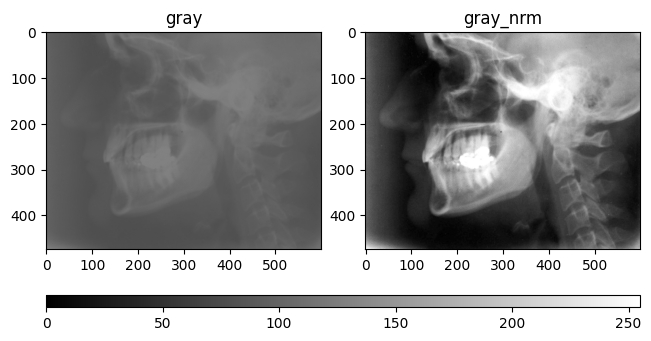

In [28]:
imshow_pair(gray=xray_gray, gray_nrm=xray_gray_nrm);

# Automatic contrast adjustment for noisy images

- Simple min-max normalization will fail when there are outlier values in the input image.
- Let's corrupt our image with artificial salt & pepper noise to illustrate the point.
- Each pixel will be randomly set to 0 or 255 with some probability (`amount` in the following code).

In [29]:
xray_gray_snp = skimage.util.random_noise(xray_gray, mode='s&p', amount=0.01)  # this also converts to float and 0..1 range
xray_gray_snp = skimage.util.img_as_ubyte(xray_gray_snp)  # convert back to uint8 and 0..255
xray_gray_snp.dtype, xray_gray_snp.shape, xray_gray_snp.min(), xray_gray_snp.max()

(dtype('uint8'), (474, 600), np.uint8(0), np.uint8(255))

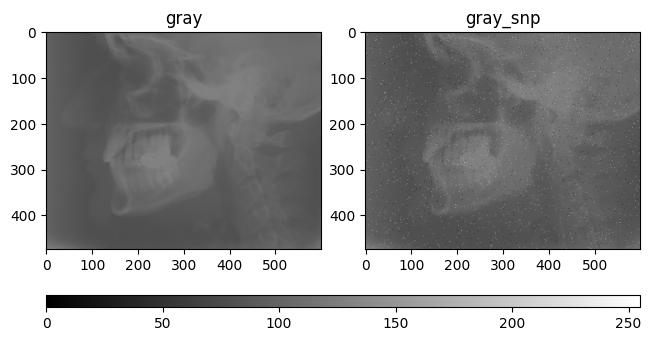

In [30]:
imshow_pair(gray=xray_gray, gray_snp=xray_gray_snp);

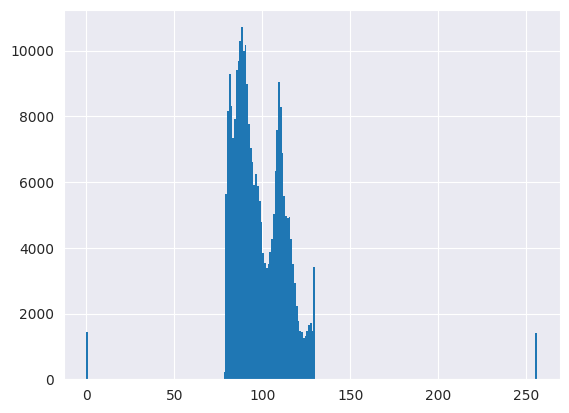

In [31]:
with sns.axes_style(style='darkgrid'):
    plt.hist(xray_gray_snp.ravel(), bins=xray_hist_bins, width=1., edgecolor='none');

In [32]:
xray_gray_snp_nrm = normalize_minmax_uint8(xray_gray_snp)
xray_gray_snp_nrm.dtype, xray_gray_snp_nrm.shape, xray_gray_snp_nrm.min(), xray_gray_snp_nrm.max()

(dtype('uint8'), (474, 600), np.uint8(0), np.uint8(255))

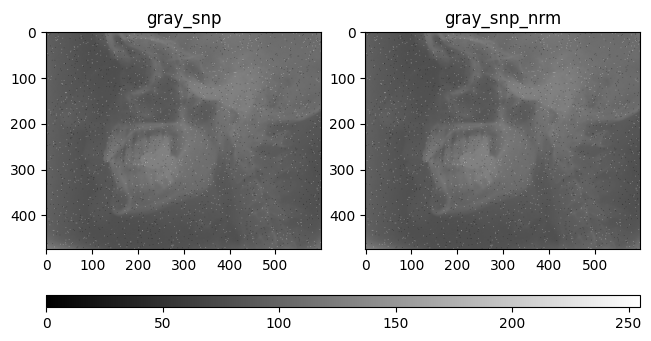

In [33]:
imshow_pair(gray_snp=xray_gray_snp, gray_snp_nrm=xray_gray_snp_nrm);

- Obviously, because the original intensity values already covered the entire `uint8` range 0..255 due to the added noise, there was nothing to "stretch".
- In order to remedy this, we would need to know the original intensity range as it was *before* the noise corruption. We don't have it, of course, so we need to estimate it.
- One idea is to assume the type of noise (salt & pepper) and the maximum amount (5 % in our case).
- Then, insted of hard max, we can set $a_\textrm{hi}$ to be a value such that 95 % of pixels in the image are smaller, i.e to the. 95th percentile, and similarly set the $a_\textrm{lo}$ to the 5th percentile.
- See the following illustration, where the percentage of pixels with the few lowest and highest values are denoted as $p_\textrm{lo}$ and $p_\textrm{hi}$, respectively.

<figure class="image">
  <img src="../figures/intensity_transformations-percentile_contrast_adjustment.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 3.6</figcaption>
</figure>

- Both values $a_\textrm{lo}$, $a_\textrm{hi}$ can be calculated using the `np.percentile` function.
- However, will do so manually using a cumulative histogram, since the `np.percentile` relies on cumulative distribution function anyway and it will be useful later for implementation of histogram equalization.

## Cumulative histogram

- If we have a histogram $h$ of our image $I$, the cumulative histogram $H$ is defined as
  $$
  H(a) = \sum_{i=0}^a h(i) \quad \textrm{for} \; 0 \le a \lt K
  $$
  where
  - $K$ is the number of intensity levels, e.g. $K = 256$ for `uint8` images.
- It holds that
  - $a$-th value in $H$ is the sum of all values in $h$ up to the $a$-th position,
  - the last element $H(K-1)$ is equal to the number of pixels in $I$. If $M$ and $N$ are the width and height of $I$, respectively, then $H(K-1) = M \cdot N$.

In [34]:
def cumsum_naive(h: np.ndarray) -> np.ndarray:
    h_cum = np.zeros_like(h)
    for a in range(len(h)):
        for i in range(a+1):
            h_cum[a] += h[i]
    return h_cum

In [35]:
def cumsum_recursive(h: np.ndarray) -> np.ndarray:
    h_cum = np.zeros_like(h)
    h_cum[0] = h[0]
    for i in range(2, len(h)):
        h_cum[i] = h_cum[i - 1] + h[i]
    return h_cum

In [36]:
np.all(cumsum_naive(xray_hist) == cumsum_recursive(xray_hist))

np.True_

In [37]:
%timeit cumsum_naive(xray_hist)

5.84 ms ± 64.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%timeit cumsum_recursive(xray_hist)

45.8 μs ± 738 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [39]:
np.all(np.cumsum(xray_hist) == cumsum_recursive(xray_hist))

np.True_

In [40]:
%timeit np.cumsum(xray_hist)

1.53 μs ± 12.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [41]:
xray_hist_cum = np.cumsum(xray_hist)
xray_hist_cum.dtype, xray_hist_cum.shape, xray_hist_cum.min(), xray_hist_cum.max()

(dtype('int64'), (256,), np.int64(0), np.int64(284400))

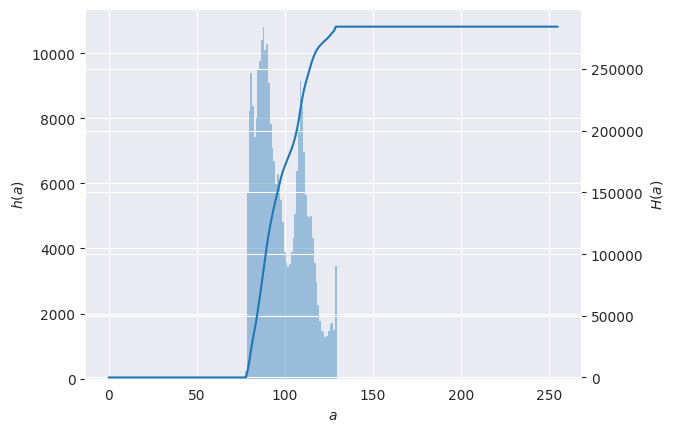

In [42]:
with sns.axes_style(style='darkgrid'):
    plt.bar(xray_hist_bins[:256], xray_hist, width=1, ec='none', alpha=0.4)
    plt.xlabel('$a$')
    plt.ylabel('$h(a)$')
    plt.gca().twinx()
    plt.plot(xray_hist_cum)
    plt.ylabel('$H(a)$')
    plt.ylim(-1000., None)

## Frequencies and probabilities

- The value in each histogram bin describes the observed frequency of the corresponding intensity value, i.e. we may treat the histogram as a discrete *frequency distribution*.
- For a given image $I$ of size $M \times N$, the sum of all histogram entries is equal to the number of pixels
  $$
  \sum_a{h(a)} = M \cdot N
  $$
- The associated normalized histogram
  $$
  p(a) = \frac{h(a)}{M \cdot N}
  $$
  can be interpreted as the probability mass function (pmf), where $p(a)$ is the probability for the occurence of the pixel value $a$. As a probability distribution, it satisfies
  $$
  \sum_a{p(a)} = 1
  $$
- The statistical counterpart to the cumulative histogram $H$ is the *cumulative distribution function*
  $$
  \textrm{cdf}(a) = \sum_{i=0}^a{p(i)} = \frac{H(a)}{M \cdot N}
  $$
- Each value $\textrm{cdf}(a)$ tells us the percentile of $a$. If, for example, $\textrm{cdf}(10) = 0.07$, it means that 7 % of pixels in the image $I$ have a value smaller or equal to $10$. The last value $\textrm{cdf}(K-1)$ (typically $K=256$ for `uint8` images) is always equal to one.

In [43]:
def pmf(h: np.ndarray) -> np.ndarray:
    return h / h.sum()

In [44]:
xray_pmf = pmf(xray_hist)
xray_pmf.shape, xray_pmf.dtype, xray_pmf.min(), xray_pmf.max()

((256,), dtype('float64'), np.float64(0.0), np.float64(0.03801336146272855))

In [45]:
def cdfs(h: np.ndarray) -> np.ndarray:
    p_cum = np.cumsum(h)
    return p_cum / p_cum[-1]

In [46]:
xray_cdf = cdfs(xray_hist)
xray_cdf.shape, xray_cdf.dtype, xray_cdf.min(), xray_cdf.max()

((256,), dtype('float64'), np.float64(0.0), np.float64(1.0))

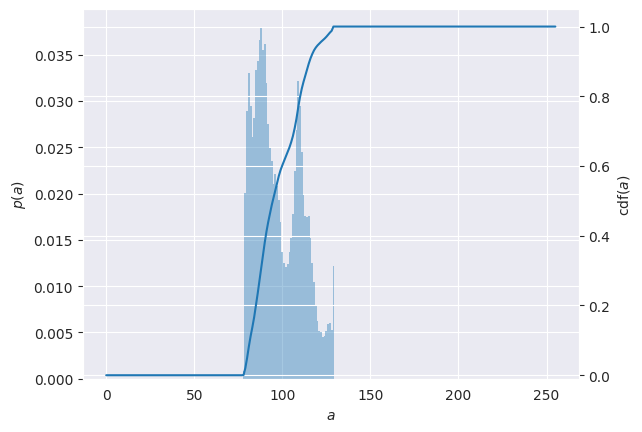

In [47]:
with sns.axes_style('darkgrid'):
    plt.bar(xray_hist_bins[:256], xray_pmf, width=1, ec='none', alpha=0.4)
    plt.xlabel('$a$')
    plt.ylabel('$p(a)$')
    plt.gca().twinx()
    plt.plot(xray_cdf)
    plt.ylabel('$\\text{cdf}(a)$')
    plt.ylim(-0.01, None)

## Normalization range limits $a_\textrm{lo}$ and $a_\textrm{hi}$ as percentiles

- Using cumulative distribution function $\textrm{cdf}$, we can easily find intensity values $a_\textrm{lo}$ and $a_\textrm{hi}$, which correspond to the smallest and largest few percent of values in $f$, respectively.
- The value $a_\textrm{lo}$ will be the first entry in the $\textrm{cdf}$ which is larger than e.g. 5 %.
- If we denote the percentage as $p_\textrm{lo}$, then
  $$
  a_\textrm{lo} = \min\left\{a | \textrm{cdf}(a) \ge p_\textrm{lo}\right\}
  $$

In [48]:
a_lo = next(a for a in range(len(xray_hist_cum)) if xray_cdf[a] >= 0.05)  # p_lo = 0.05
a_lo

81

Similarly, $a_\textrm{hi}$ will be the last $a$ for which $\textrm{cdf}(a) \le 0.95$, i.e.
$$
a_\textrm{hi} = \max\left\{a | \textrm{cdf}(a) \le (1 - p_\textrm{hi})\right\}
$$

In [49]:
a_hi = next(a for a in reversed(range(len(xray_hist_cum))) if xray_cdf[a] <= 0.95)  # p_hi = 0.05
a_hi

120

Let's put the entire percentile-based contrast adjustment into single function.

In [50]:
def normalize_percentile_uint8(img: np.ndarray, percentage: float = 0.05) -> np.ndarray:
    h, _ = np.histogram(img.ravel(), bins=np.arange(257))
    p_cum = cdfs(h)
    a_lo = next(a for a in range(len(p_cum)) if p_cum[a] > percentage)
    a_hi = next(a for a in reversed(range(len(p_cum))) if p_cum[a] < 1. - percentage)
    output = 255. / (a_hi - a_lo) * (img.astype(float) - a_lo)
    return output.clip(min=0, max=255).astype(np.uint8)

In [51]:
gray_snp_nrp = normalize_percentile_uint8(xray_gray_snp, percentage=0.05)  # try lowering percentile here
gray_snp_nrp.dtype, gray_snp_nrp.shape, gray_snp_nrp.min(), gray_snp_nrp.max()

(dtype('uint8'), (474, 600), np.uint8(0), np.uint8(255))

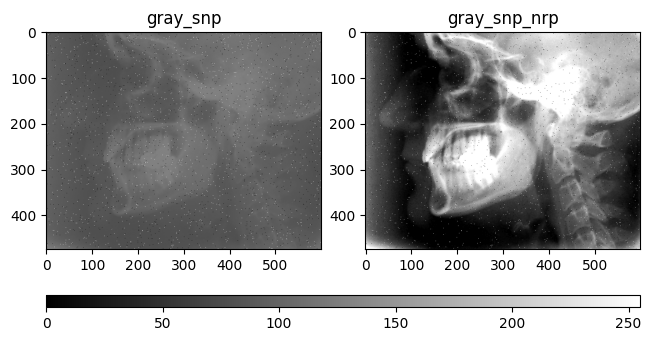

In [52]:
imshow_pair(gray_snp=xray_gray_snp, gray_snp_nrp=gray_snp_nrp);

# Intensity transformations as an application of the function $T$

- Notice that in all of the examples above, the procedure for transforming the input image using a monadic transformation function $T$ was always the same.
- The only thing that varied was the function $T$.
- Therefore, we may create a general function `remap_values` that takes in two inputs: image $f$ and transformation $T$.

In [53]:
def remap_values(img: np.ndarray, trf_func: Callable[[float], float]) -> np.ndarray:
    height, width = img.shape
    output = np.zeros_like(img)
    for y in range(height):
        for x in range(width):
            output[y, x] = trf_func(img[y, x])
    return output

## Inverting an image (image negative)

- Now, we'll look at image negative again.
- This time, however, we will perform it using the `remap_values` function.
- Remember that the image negative transformation function is
  $$
  T_\textrm{neg}(a) = a_\textrm{max} - a
  $$
- For `uint8`, $a_\textrm{max} = 255$. Let's create $T_\textrm{neg}$ as a Python function.

In [54]:
def trf_neg(a: float) -> float:
    return 255 - a

In [55]:
xray_neg = remap_values(xray_gray, trf_neg)
xray_neg.dtype, xray_neg.shape, xray_neg.min(), xray_neg.max()

(dtype('uint8'), (474, 600), np.uint8(126), np.uint8(177))

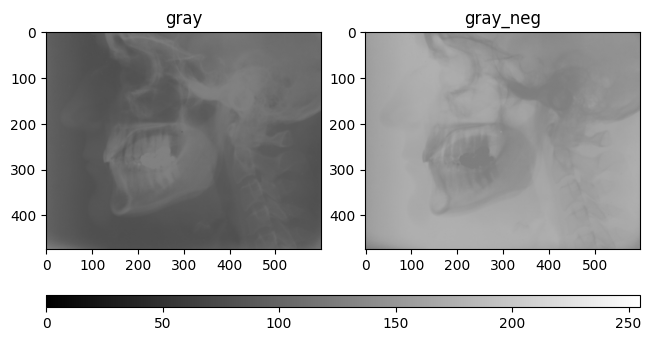

In [56]:
imshow_pair(gray=xray_gray, gray_neg=xray_neg);

## Pre-computing $T$ as a <u>l</u>ook<u>u</u>p <u>t</u>able (LUT)

- When we are working with discrete images with finite number of distinct pixel values, the transformation function $T(a)$ will be a discrete function with a finite number of distinct values of $a$.
- Typically, for `uint8`, $a = 0,\ldots,255$.
- We may then pre-compute the output values $T(a)$ so that $T$ need not to be re-evaluated for each pixel inside the for loop of `remap_values`.
- We'll create another function `remap_values_uint8`, in which the second argument will be a vector of size 256 with pre-computed values of $T$ instead of $T$ itself.

In [57]:
def remap_values_uint8(img: np.ndarray, trf_lut: np.ndarray) -> np.ndarray:
    height, width = img.shape
    output = np.zeros_like(img)
    for y in range(height):
        for x in range(width):
            output[y, x] = trf_lut[img[y, x]]
    return output

In [58]:
def create_image_negative_lut() -> np.ndarray:
    return 255 - np.arange(256, dtype=np.uint8)

In [59]:
lut_neg = create_image_negative_lut()
lut_neg.shape, lut_neg.dtype, lut_neg.min(), lut_neg.max()

((256,), dtype('uint8'), np.uint8(0), np.uint8(255))

In [60]:
def plot_lut(lut: np.ndarray, ax: Optional[plt.matplotlib.axes.Axes] = None):
    if ax is None:
        ax = plt.gca()
    ax.plot(lut);
    ax.set_xlabel('$a$')
    ax.set_ylabel('$a\'$')

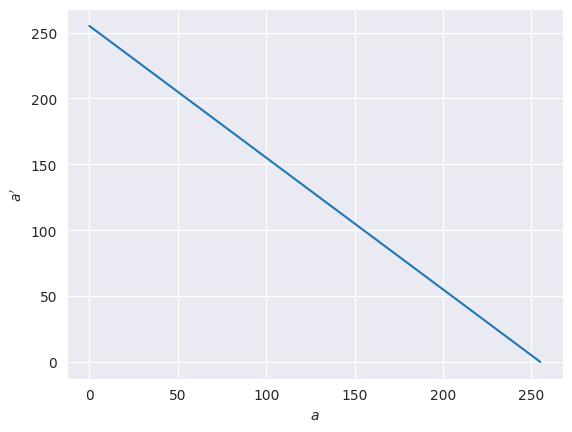

In [61]:
with sns.axes_style(style='darkgrid'):
    plot_lut(lut_neg)

In [62]:
xray_neg = remap_values_uint8(xray_gray, lut_neg)
xray_neg.dtype, xray_neg.shape, xray_neg.min(), xray_neg.max()

(dtype('uint8'), (474, 600), np.uint8(126), np.uint8(177))

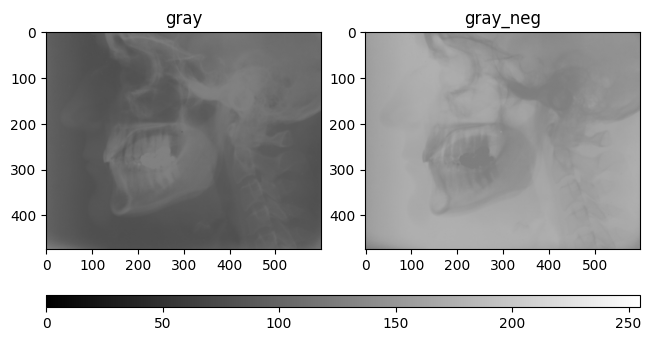

In [63]:
imshow_pair(gray=xray_gray, gray_neg=xray_neg);

- We can verify that the LUT approach is significantly faster.

In [64]:
%timeit remap_values(xray_gray, trf_neg)

60.6 ms ± 844 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
%timeit remap_values_uint8(xray_gray, lut_neg)

57 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Moreover, we can take advantage of highly optimized Numpy indexing and speed up the transformation even further.
- Since we need just one line, we'll not even implement it as a function.

In [66]:
xray_neg = lut_neg[xray_gray]
xray_neg.dtype, xray_neg.shape, xray_neg.min(), xray_neg.max()

(dtype('uint8'), (474, 600), np.uint8(126), np.uint8(177))

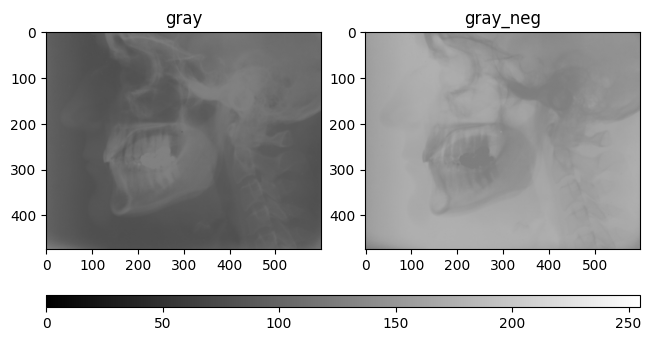

In [67]:
imshow_pair(gray=xray_gray, gray_neg=xray_neg);

In [68]:
%timeit lut_neg[xray_gray]

468 μs ± 10.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Thresholding via LUT

In [69]:
def create_thresholding_lut(threshold: int) -> np.ndarray:
    lut = np.zeros(256, dtype=np.uint8)
    lut[threshold:] = 255
    return lut

In [70]:
lut_thr = create_thresholding_lut(125)

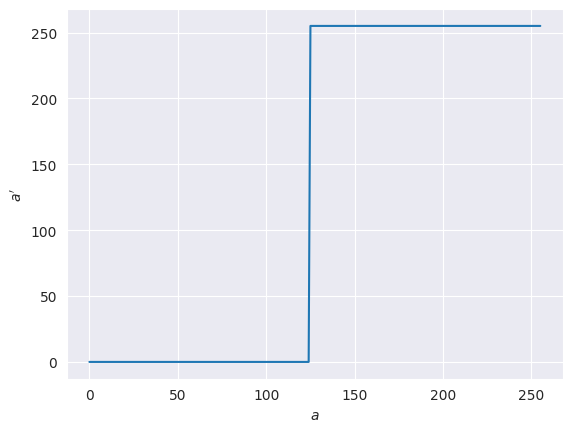

In [71]:
with sns.axes_style(style='darkgrid'):
    plot_lut(lut_thr)

In [72]:
gray_thr = lut_thr[xray_gray]
gray_thr.dtype, gray_thr.shape, gray_thr.min(), gray_thr.max()

(dtype('uint8'), (474, 600), np.uint8(0), np.uint8(255))

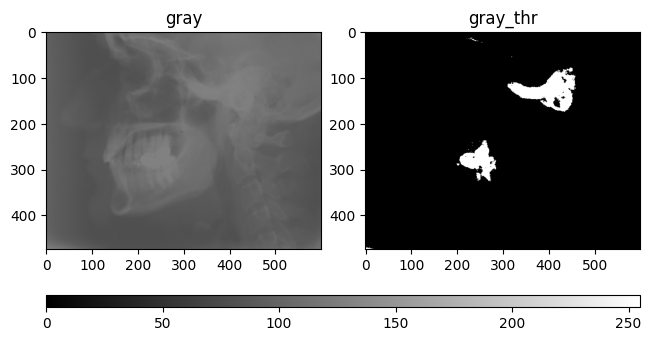

In [73]:
imshow_pair(gray=xray_gray, gray_thr=gray_thr);

## Contrast adjustment via LUT

In [74]:
def create_contrast_adjustment_lut(a_lo: int, a_hi: int, a_min: int, a_max: int) -> np.ndarray:
    lut = (a_max - a_min) / (a_hi - a_lo) * (np.arange(256, dtype=float) - a_lo) + a_min
    return lut.clip(0, 255).astype(np.uint8)

In [75]:
lut_adj = create_contrast_adjustment_lut(a_lo, a_hi, 0, 255)

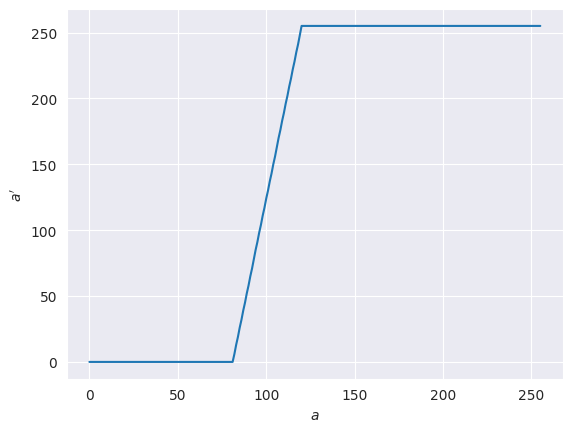

In [76]:
with sns.axes_style(style='darkgrid'):
    plot_lut(lut_adj)

In [77]:
xray_gray_nrm = lut_adj[xray_gray]
xray_gray_nrm.shape, xray_gray_nrm.dtype, xray_gray_nrm.min(), xray_gray_nrm.max()

((474, 600), dtype('uint8'), np.uint8(0), np.uint8(255))

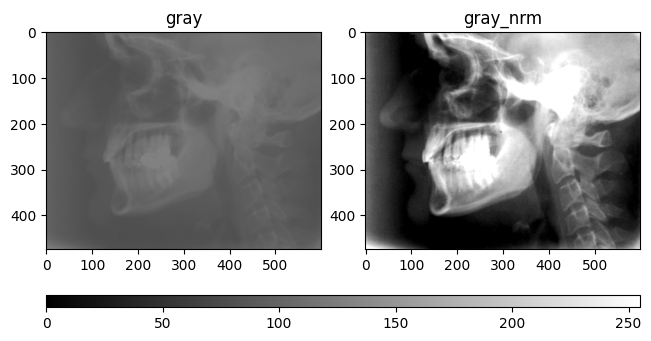

In [78]:
imshow_pair(gray=xray_gray, gray_nrm=xray_gray_nrm);

# Histogram equalization

- The goal of histogram equalization is to find a value mapping such that the histogram of the remmaped image approximates a uniform distribution.
- The resulting image will appear as high contrast, since all possible rightness values will be utilized in roughly the same amount.
- The principle is illustrated in the following figure. We are trying to find a mapping that shifts the histogam such that the resulting cumulative histogram resembles a linear ramp, i.e. like an ideal uniformly distributed image would.

<figure class="image">
  <img src="../figures/intensity_transformations-cumulative_histogram.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 3.8 and 3.9</figcaption>
</figure>

- Basically, the idea is to stretch all dense clusters of similar values to be farther apart, in order to make them visually more distinct.
- This is similar to e.g. automatic contrast adjustment, but equalization remaps the values non-linearly based on local histogram density
- The desired operation is obtained from the cumulative histogram $H$ of the original image as
  $$
  T_\text{eq}(a) = \text{round}\left( H(a) \cdot \frac{K-1}{M \cdot N} \right) = \text{round}\left( \text{cdf}(a) \cdot (K-1) \right)
  $$
- Note: we use $\text{round}$ instead of $\text{floor}$ that is used in \[Burger22\] in order to match the implementation in scikit-image.

In [79]:
def create_histogram_equalization_lut(h: np.ndarray) -> np.ndarray:
    h_cum = cdfs(h)
    lut = np.round(h_cum * 255)
    return lut.astype(np.uint8)

- Let's try histogram equalization with noisy image to demonstrate its robustness.

In [80]:
lut_equ = create_histogram_equalization_lut(np.histogram(xray_gray_snp, bins=np.arange(257))[0])

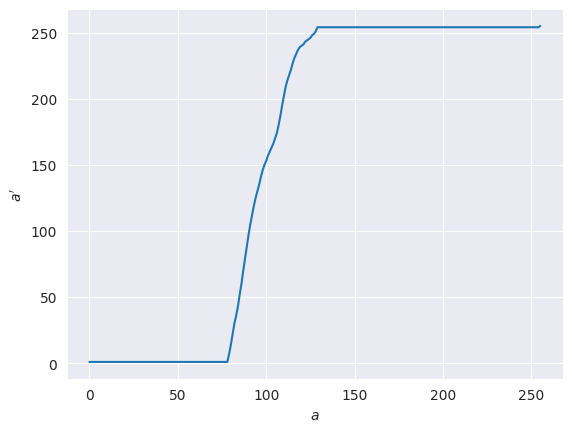

In [81]:
with sns.axes_style(style='darkgrid'):
    plot_lut(lut_equ)

In [82]:
xray_gray_snp_equ = lut_equ[xray_gray_snp]
xray_gray_snp_equ.shape, xray_gray_snp_equ.dtype, xray_gray_snp_equ.min(), xray_gray_snp_equ.max()

((474, 600), dtype('uint8'), np.uint8(1), np.uint8(255))

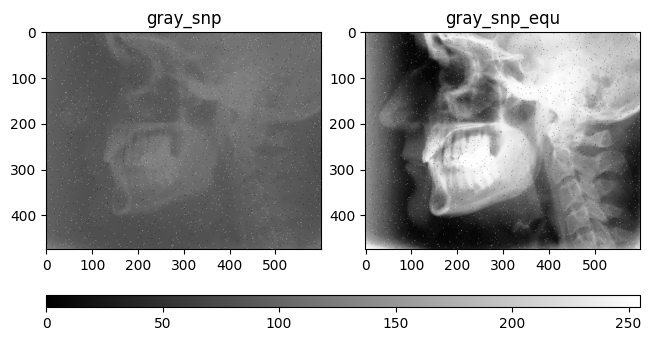

In [83]:
imshow_pair(gray_snp=xray_gray_snp, gray_snp_equ=xray_gray_snp_equ);

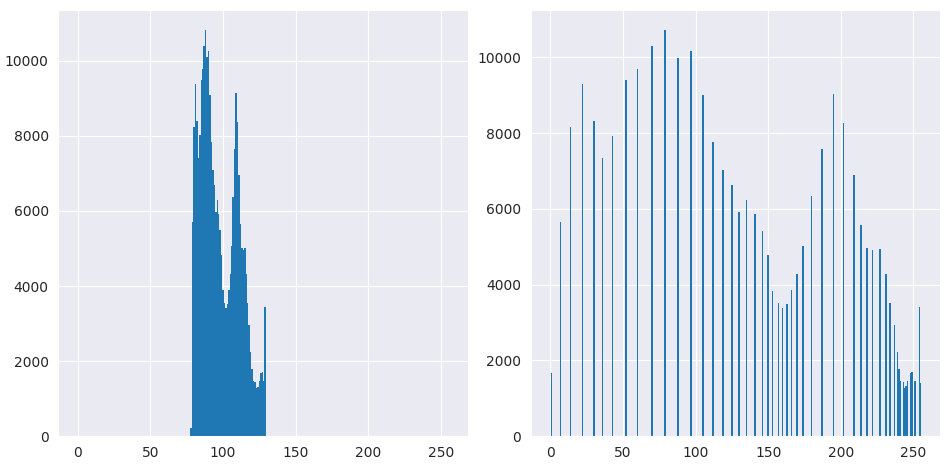

In [84]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=plt.figaspect(0.5))
    plt.subplot(1, 2, 1)
    plt.bar(xray_hist_bins[:256], xray_hist, width=1., edgecolor='none')
    plt.subplot(1, 2, 2)
    plt.bar(xray_hist_bins[:256], np.histogram(xray_gray_snp_equ, bins=xray_hist_bins)[0], width=1., edgecolor='none')
    plt.tight_layout()

# Histogram matching

We also may want to remap one image in such a way that the resulting histogram will aproximate a histogram of another image.

<figure class="image">
  <img src="../figures/intensity_transformations-histogram_matching.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 3.11</figcaption>
</figure>

In [85]:
def create_histogram_match_lut(h_input: np.ndarray, h_ref: np.ndarray) -> np.ndarray:
    cdf_input = cdfs(h_input)
    cdf_ref = cdfs(h_ref)
    lut = np.zeros(len(h_input), dtype=np.uint8)
    for a in range(len(h_input)):
        try:
            # Find the highest intensity in the reference cumulative histogram
            # that is smaller than a-th entry of the input cumulative histogram
            lut[a] = next(i for i in reversed(range(len(h_input))) if cdf_input[a] > cdf_ref[i])
        except StopIteration:
            # If all reference intensities have higher percentiles, then default to 0
            lut[a] = 0
    return lut

In [86]:
h_refs = [
    scipy.stats.beta(alpha, beta).pdf(np.linspace(0.01, 0.99, 256))
    for alpha, beta in ((0.5, 0.5), (5., 1.), (1., 3.), (2., 2.))
]

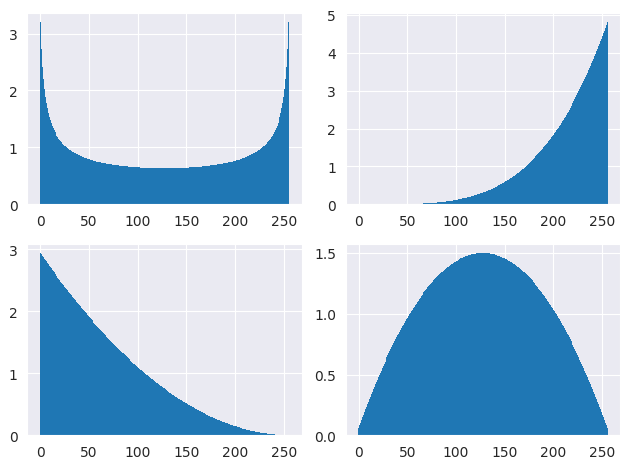

In [87]:
# Let's try 4 different refence histograms
with sns.axes_style('darkgrid'):
    for a, h_ref in enumerate(h_refs):
        plt.subplot(2, 2, a + 1)
        plt.bar(xray_hist_bins[:256], h_ref, width=1, edgecolor='none');
    plt.tight_layout()

In [88]:
# For each reference histogram, create corresponding matching LUT
lut_mchs = [
    create_histogram_match_lut(xray_hist, h_ref)
    for h_ref in h_refs
]

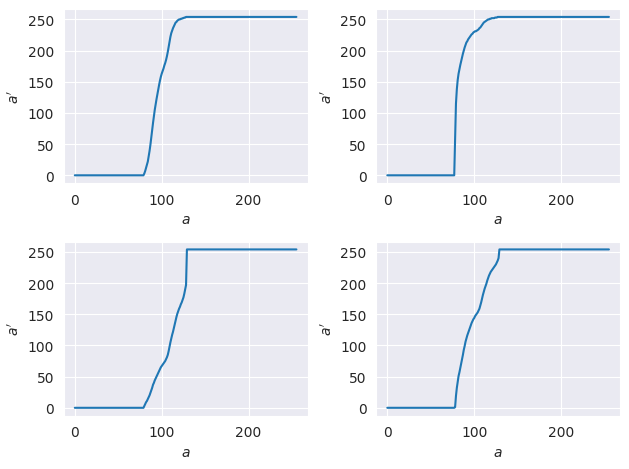

In [89]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(2, 2)
    for ax, lut_mch in zip(axes.flat, lut_mchs):
        plot_lut(lut_mch, ax=ax);
    plt.tight_layout()

In [90]:
# Perform the matching using the computed LUTs
xray_gray_mchs = [lut_mch[xray_gray] for lut_mch in lut_mchs]

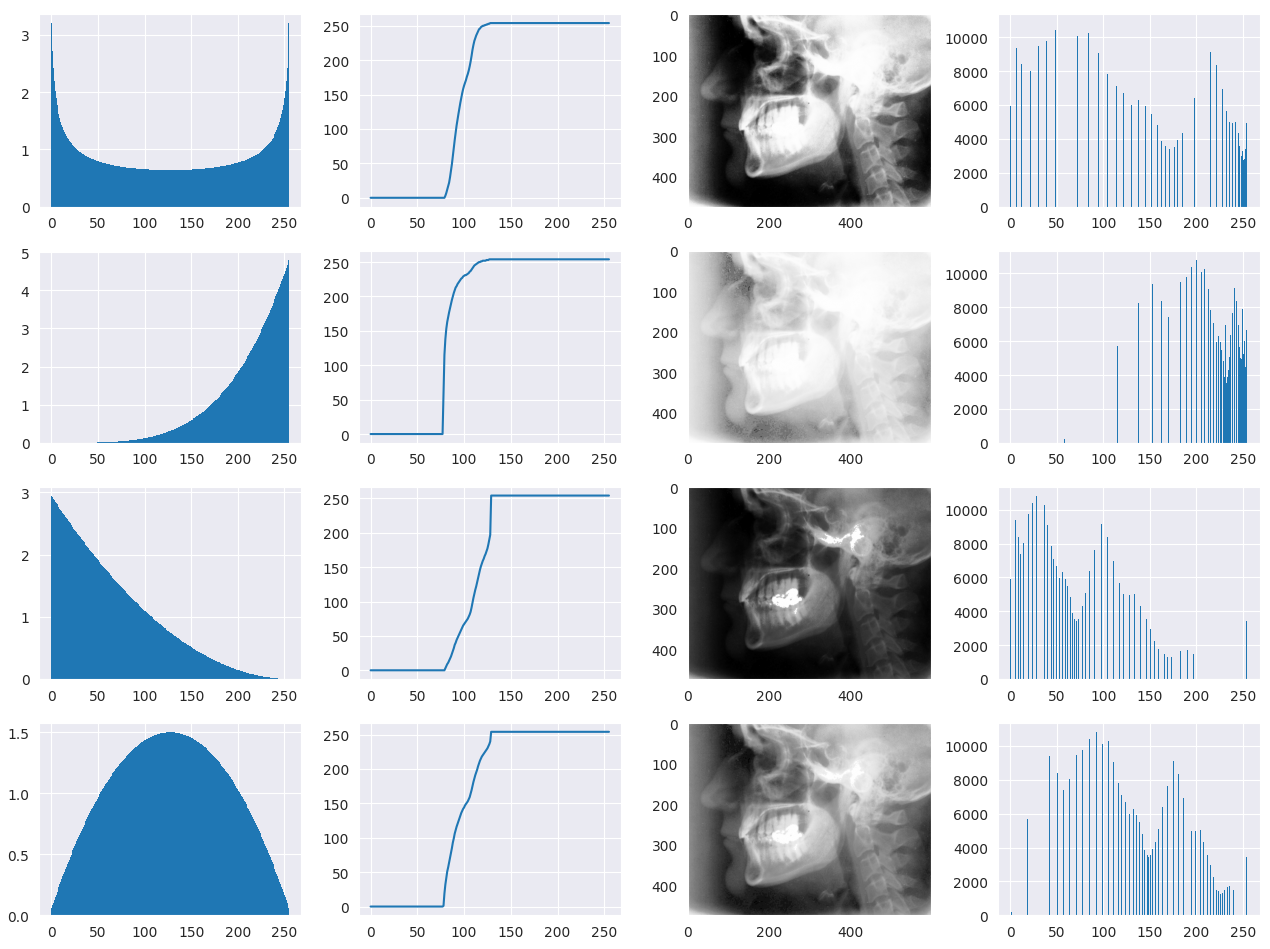

In [91]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(4, 4, figsize=(2. * plt.rcParams['figure.figsize'][0], 2. * plt.rcParams['figure.figsize'][1]))
    for i, (h_ref, lut_mch, gray_mch) in enumerate(zip(h_refs, lut_mchs, xray_gray_mchs)):
        axes[i, 0].bar(xray_hist_bins[:256], h_ref, edgecolor='none', width=1.)  # 1st column: target histogram
        axes[i, 1].plot(lut_mch);  # 2nd column: mapping function (LUT)
        axes[i, 2].imshow(gray_mch, cmap='gray', vmin=0, vmax=255);  # 3rd column: remapped image
        axes[i, 2].grid(False)
        axes[i, 3].bar(xray_hist_bins[:256], np.histogram(gray_mch, bins=xray_hist_bins)[0], edgecolor='none', width=1.)  # 4th column: histogram of the remapped image
    plt.tight_layout();

# Gamma correction

Usually, the relationship between physical signal amplitude such as light intensity emitted by an LCD screen and its input voltage, or vice versa, charge accumulated on a camera chip and the converted intensity, is non-linear. Perhaps surprisingly, a lot of these relationships can be modeled as an exponential function of the form
$$
T_\text{gam}(a; \gamma) = a^\gamma
$$
where
- $\gamma \in \mathbb{R}$ is a parameter called gamma value.

Depending on the gamma value, the function can look like the following figure.

<figure class="image">
  <img src="../figures/intensity_transformations-gamma_function.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 3.19</figcaption>
</figure>

We may use $f(a)$ in a process called *gamma correction*, in which we try to linearize the input-output relationship in order to standardize stored values across different devices. See the following figure.

<figure class="image">
  <img src="../figures/intensity_transformations-gamma_correction.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 3.21</figcaption>
</figure>

In [92]:
lut_gams = [
    (255 * np.linspace(0., 1., 256) ** gamma).astype(np.uint8)
    for gamma in (1/20, 1/5, 1/2, 2, 5, 20)
]

In [93]:
# Perfrom gamma correction for each gamma LUT
gray_gams = [lut[xray_gray] for lut in lut_gams]

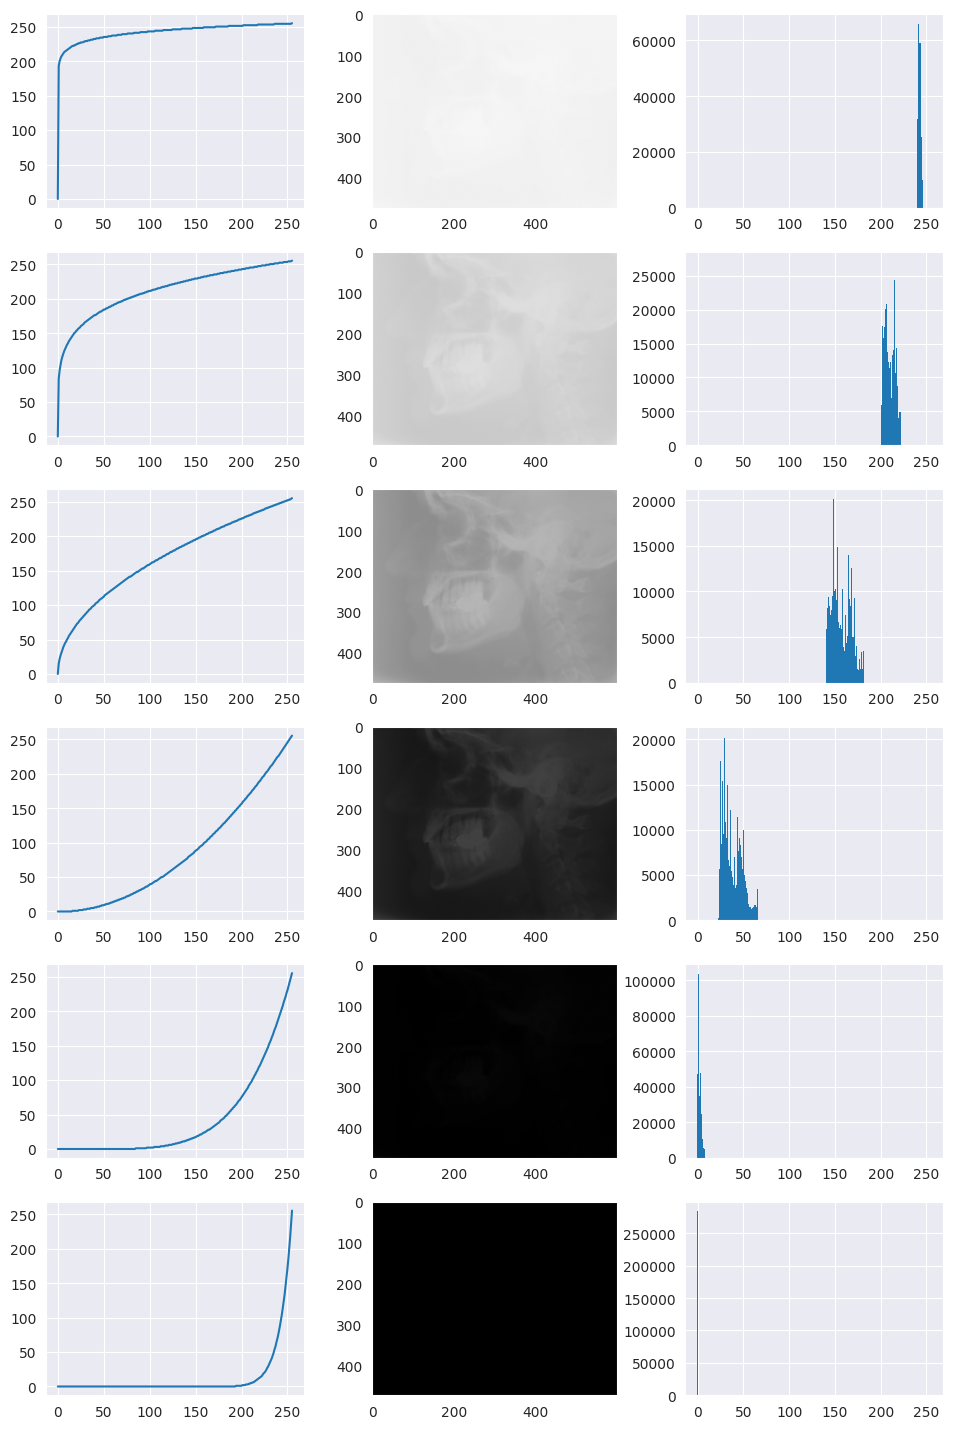

In [94]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(6, 3, figsize=(1.5 * plt.rcParams['figure.figsize'][0], 3. * plt.rcParams['figure.figsize'][1]))
    for i, (lut_gam, gray_gam) in enumerate(zip(lut_gams, gray_gams)):
        axes[i, 0].plot(lut_gam);  # 1st column: mapping function (LUT)
        axes[i, 1].imshow(gray_gam, cmap='gray', vmin=0, vmax=255);  # 2nd column: remapped image
        axes[i, 1].grid(False)
        axes[i, 2].bar(xray_hist_bins[:256], np.histogram(gray_gam, bins=xray_hist_bins)[0], ec='none', width=1.)  # 3rd column: histogram of the remapped image
    plt.tight_layout();

# Comparison of intensity transformations

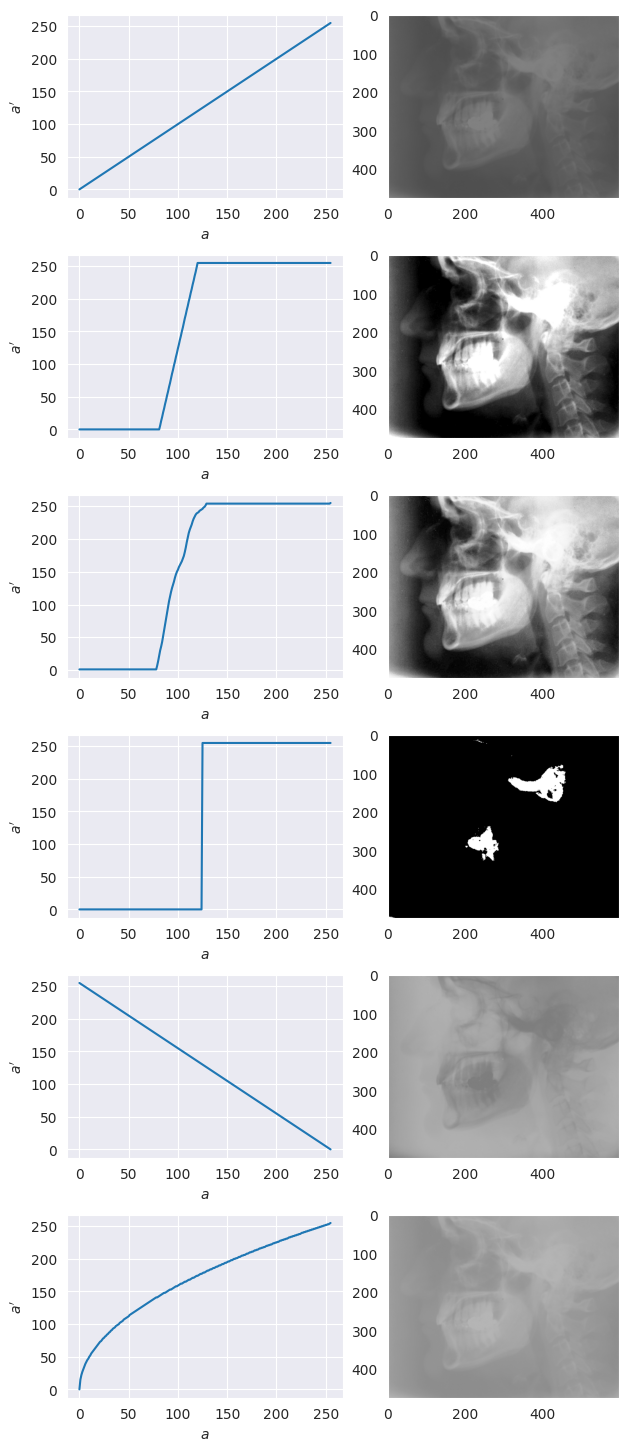

In [95]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(nrows=6, ncols=2, constrained_layout=True, figsize=(plt.rcParams['figure.figsize'][0], 3*plt.rcParams['figure.figsize'][1]))
    for axr, lut in zip(axes, [np.arange(256), lut_adj, lut_equ, lut_thr, lut_neg, lut_gams[2]]):
        plot_lut(lut, ax=axr[0])  #axr[0].plot(lut);
        axr[1].imshow(lut[xray_gray], cmap='gray', vmin=0, vmax=255)
        axr[1].grid()

# Intensity transformations dependent on position

- Remember that in general, intensity transformation is
  $$
  g(x, y) = T(f(x, y), x, y)
  $$
  which means that the function $T$ could also take into account the pixel location $(x, y)$.
- An example of this could be non-uniform illumination correction or application of a visual effect to the image.

## Vignette effect

- We will implement the vignette effect as a simple multiplication between the original image $f$ and the vignette $w$, i.e.
  $$
  g(x,y) = T_\text{vig}(f(x,y),x,y) = f(x,y) \cdot w(x,y)
  $$
- The vignette $w$ will be a 2D "weight mask" with values in the range $w(x,y) \in [0, 1]$.
- In the middle, we will have ones, near the corners we'll have smaller values.

In [96]:
spider_rgb = skimage.io.imread('../data/spider.jpg')

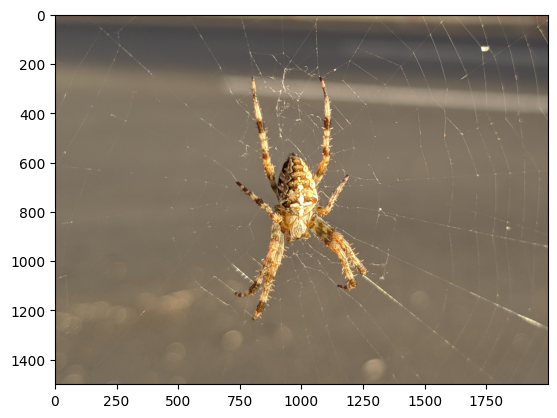

In [97]:
plt.imshow(spider_rgb);

- There are multiple ways to produce the vignette weights.
- One way is to to calculate (axis normalized) distance from the center.

In [98]:
# vignette
x, y = np.meshgrid(np.arange(spider_rgb.shape[1]), np.arange(spider_rgb.shape[0]))
xc, yc = spider_rgb.shape[1] / 2, spider_rgb.shape[0] / 2
dx2 = (x - xc) ** 2 / spider_rgb.shape[1] ** 2
dy2 = (y - yc) ** 2 / spider_rgb.shape[0] ** 2
vig_dist = np.clip(1.2 - np.sqrt(dx2 + dy2), 0., 1.)

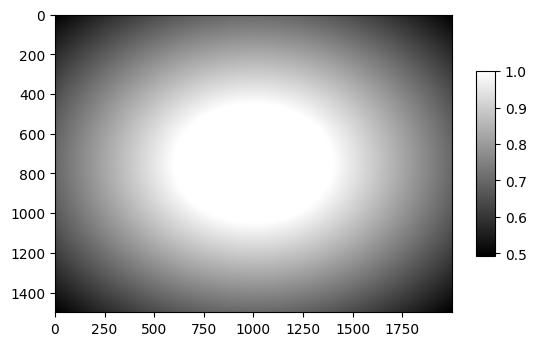

In [99]:
# with sns.axes_style('dark'):
plt.imshow(vig_dist, cmap='gray')
plt.colorbar(shrink=0.5, aspect=10);

- Alternatively, we can use 2D Gaussian distribution with the shape of the input image.

In [100]:
x, y = np.meshgrid(np.arange(spider_rgb.shape[1]), np.arange(spider_rgb.shape[0]))
xc, yc = spider_rgb.shape[1] / 2, spider_rgb.shape[0] / 2
vig_gauss = np.clip(-1. + 2.15 * np.exp(-(x - xc) ** 2 / spider_rgb.shape[1] ** 2 - (y - yc) ** 2 / spider_rgb.shape[0] ** 2), 0., 1.)

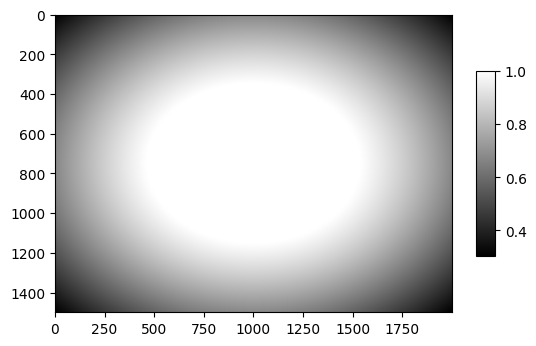

In [101]:
# with sns.axes_style('dark'):
plt.imshow(vig_gauss, cmap='gray')
plt.colorbar(shrink=0.5, aspect=10);

- We will multiply the input image `rgb` by the vignette weights (`vig_*` matrix).

In [102]:
# channel by channel
spider_rgb_vig = np.zeros(spider_rgb.shape, dtype=spider_rgb.dtype)
for c in range(spider_rgb.shape[2]):
    spider_rgb_vig[..., c] = vig_dist * spider_rgb[..., c]  # change here to `vig_gauss for different vignette`
spider_rgb_vig.dtype

dtype('uint8')

In [103]:
# broadcasting
spider_rgb_vig = (vig_gauss[..., None] * spider_rgb).astype(np.uint8)  # change here to `vig_gauss for different vignette`
spider_rgb_vig.dtype, spider_rgb_vig.shape

(dtype('uint8'), (1500, 2000, 3))

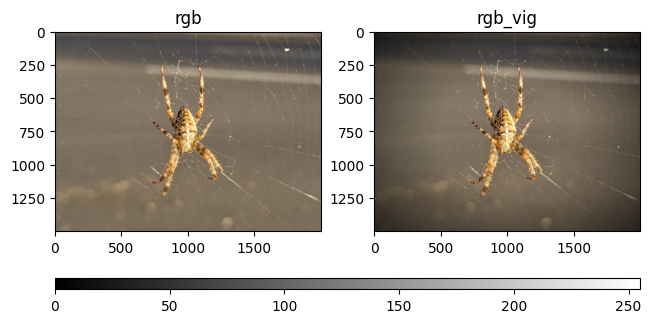

In [104]:
imshow_pair(rgb=spider_rgb, rgb_vig=spider_rgb_vig);

## Adaptive Histogram Equalization (AHE)

- If different parts of the image have very different exposure and contrast, we may want to equalize each part separately.
- In general, we could equalize each pixel independently of others where each histogram is computed from its neighborhood.

<figure class="image">
  <img src="../figures/intensity_transformations-ahe_neighborhoods.svg" alt="" style="width: 6.4in;"/>
  <figcaption>Source: <a href="https://en.wikipedia.org/wiki/Adaptive_histogram_equalization">https://en.wikipedia.org/wiki/Adaptive_histogram_equalization</a></figcaption>
</figure>

- However, this would be computiationally prohibitive, so one of several measures is usually applied, for example
  1. Compute the histogram incrementally instead of recomputing at each pixel,
  2. compute only few histograms over different parts of the image and then linearly interpolate between them.
- We'll show the second approach here as an example:
  1. Divide the $M \times N$ image into regular grid of square or rectangular tiles of size $K \times L$,
  2. compute a local histogram and intensity transformation $T$ independently in each tile,
  3. loop over all pixels of the image and use the appropriate local $T$ corresponding to its location.  
  - In order to prevent "blockiness" of the resulting image due to tiles having different intensity transformation functions, instead of just using one local $T$ of the current tile we will average the result of local $T$ functions of the 4 neighboring tiles.  
  - The average will be weighted based on the pixel's position inside the tile - this process is called **(bi)linear interpolation**.

<figure class="image">
  <img src="../figures/intensity_transformations-ahe_interpolation.svg" alt="" style="width: 6.4in;"/>
  <figcaption>Source: <a href="https://en.wikipedia.org/wiki/Adaptive_histogram_equalization">https://en.wikipedia.org/wiki/Adaptive_histogram_equalization</a></figcaption>
</figure>

- Size of the tile is a hyper-parameter of the algorithm and has significant impact on the result.

In [105]:
def adaptive_histogram_equalization(
    img: np.ndarray,
    tile_size: tuple[int, int] = (64, 64),
) -> np.ndarray:
    """
    Args:
        img: Input grayscale image (2D numpy array of dtype uint8).
        tile_size: Size of the tiles to divide the image into (height, width).
    Returns:
        Equalized image (2D numpy array of dtype uint8).
    """
    im_h, im_w = img.shape
    t_h, t_w = tile_size
    g_h, g_w = ((im_h + t_h - 1) // t_h, (im_w + t_w - 1) // t_w)

    # Divide image into tiles, add padding if necessary
    pad_h = t_h * g_h - im_h  # bottom padding
    pad_w = t_w * g_w - im_w  # right padding
    padded = np.pad(img, ((0, pad_h), (0, pad_w)), mode='symmetric')

    # Build a histogram for each tile
    bins = np.arange(257)
    hists = np.zeros((g_h, g_w, 256), dtype=np.int32)
    for ty in range(g_h):
        for tx in range(g_w):
            tile = padded[ty * t_h : (ty + 1) * t_h, tx * t_w : (tx + 1) * t_w]
            hists[ty, tx], _ = np.histogram(tile, bins=bins)

    # Normalize the histogram into CDF for each tile; these will be used as intensity transformations LUTs for remapping
    # Note: we use float values between 0 and 1 instead of uint8 to avoid rounding errors during the interpolation
    cdfs = hists.cumsum(axis=2).astype(float)
    cdfs /= cdfs[:, :, [-1]]

    # Remap every pixel using bilinear interpolation (weighted average) of the CDFs of the four nearest tiles
    equ = np.zeros_like(img)
    for y in range(im_h):
        # Find the grid coordinate in the *y* direction and the neighboring tile
        # We set the center to the middle of the tile
        u = y / t_h - 0.5
        if 0.0 < u < g_h - 1.0:
            # If the coords are "nice" and far from the borders, use the "floor-th" and "ceil-th" tiles
            i1 = max(0, min(int(u), g_h - 1))
            i2 = min(i1 + 1, g_h - 1)
        else:
            # If the coords are close to the borders, only use single nearest tile
            i1 = i2 = max(0, min(int(u), g_h - 1))
        dy = u - i1  # weight (aka one minus distance) in y direction

        for x in range(im_w):
            # The same calculation of the grid coordinate but for the *x* direction
            v = x / t_w - 0.5
            if 0.0 < v < g_w - 1.0:
                j1 = max(0, min(int(v), g_w - 1))
                j2 = min(j1 + 1, g_w - 1)
            else:
                j1 = j2 = max(0, min(int(v), g_w - 1))
            dx = v - j1

            # Get the gray level (0-255) of the current pixel
            a = img[y, x]

            # b = T(a) is a bilinear interpolation of the neighboring CDFs
            b = (
                  (1 - dy) * (1 - dx) * cdfs[i1, j1, a]
                + (1 - dx) *    dy    * cdfs[i2, j1, a]
                +    dx    * (1 - dy) * cdfs[i1, j2, a]
                +    dx    *    dy    * cdfs[i2, j2, a]
            )

            # Convert back from [0, 1] to [0, 255] range and write to output image
            equ[y, x] = int(b * 255 + 0.5)

    return equ

In [106]:
xray_ahe = adaptive_histogram_equalization(xray_gray)  # try larger tile_size=(128, 128)
xray_ahe.dtype, xray_ahe.shape, xray_ahe.min(), xray_ahe.max()

(dtype('uint8'), (474, 600), np.uint8(0), np.uint8(255))

In [107]:
xray_equ = lut_equ[xray_gray]
xray_equ.dtype, xray_equ.shape, xray_equ.min(), xray_equ.max()

(dtype('uint8'), (474, 600), np.uint8(1), np.uint8(254))

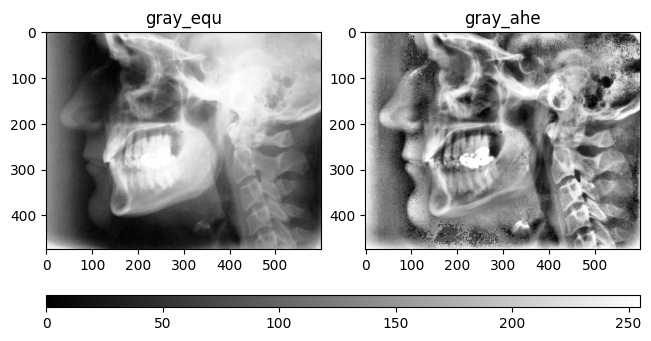

In [108]:
imshow_pair(gray_equ=xray_equ, gray_ahe=xray_ahe);

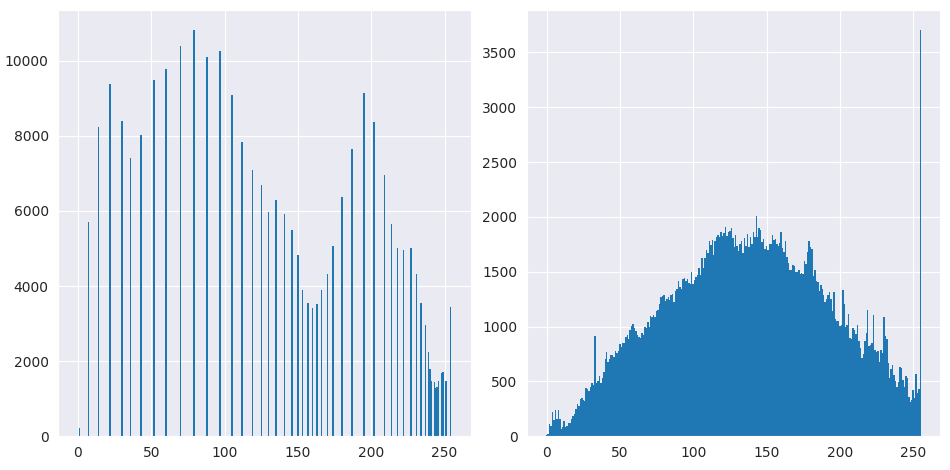

In [109]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=plt.figaspect(0.5))
    plt.subplot(1, 2, 1)
    plt.bar(xray_hist_bins[:256], np.histogram(xray_equ, bins=xray_hist_bins)[0], width=1., edgecolor='none')
    plt.subplot(1, 2, 2)
    plt.bar(xray_hist_bins[:256], np.histogram(xray_ahe, bins=xray_hist_bins)[0], width=1., edgecolor='none')
    plt.tight_layout()

## Contrast Limited Adaptive Histogram Equalization (CLAHE)

- Naïve adaptive histogram equalization has several problems.
- Most importantly, it over-enhances uniform areas with mostly one shade of gray that have a "peaky" local histogram.
- This significantly amplifies noise as can be seen in our adaptively equalized X-ray image above.
- One solution is to limit the slope of all the local intensity transformation functions $b = T(a)$, because the slope is what determinhes the output contrast.
- However, instead of directly manipulating the slope it is easier to smooth the histogram before computing the CDF and its $T$.
- In CLAHE, the smoothing is done by
  1. **clipping** too high values,
  2. and **redistributing** it uniformly among other bins.

<figure class="image">
  <img src="../figures/intensity_transformations-clahe_hist_redist.svg" alt="" style="width: 6.4in;"/>
  <figcaption>Source: <a href="https://en.wikipedia.org/wiki/Adaptive_histogram_equalization">https://en.wikipedia.org/wiki/Adaptive_histogram_equalization</a></figcaption>
</figure>

- Note that after redistributing, we may end up with some values over the limit again, so we may need to redistribute iteratively until no value exceeds the limit.
- Lower and more uniformly distributed values in the histogram mean the resulting $T(a)$ cannot be too steep.

### CLAHE in scikit-image

In [110]:
xray_clahe = skimage.exposure.equalize_adapthist(xray_gray)  # try clip_limit=1.0
xray_clahe = skimage.util.img_as_ubyte(xray_clahe)
xray_clahe.dtype, xray_clahe.shape, xray_clahe.min(), xray_clahe.max()

(dtype('uint8'), (474, 600), np.uint8(0), np.uint8(255))

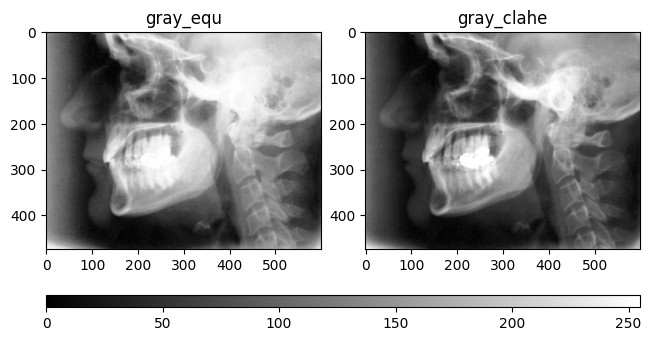

In [111]:
imshow_pair(gray_equ=xray_equ, gray_clahe=xray_clahe);